# Julia for Data Science

* Data
* **Data processing**
* Visualization

### Data processing: Standard machine learning algorithms in Julia
In what's next, we will see how to use some of the standard machine learning algorithms implemented in Julia.

In [1]:
using JuliaDB

Let's start with some data.

The Sacramento real estate transactions file that we download next is a list of 985 real estate transactions in the Sacramento area reported over a five-day period,

In [2]:
houses = loadtable("houses.csv")

Table with 985 rows, 12 columns:
Columns:
#   colname    type
──────────────────────
1   street     String
2   city       String
3   zip        Int64
4   state      String
5   beds       Int64
6   baths      Int64
7   sq__ft     Int64
8   type       String
9   sale_date  String
10  price      Int64
11  latitude   Float64
12  longitude  Float64

Let's use `Plots` to plot with the `pyplot` backend.

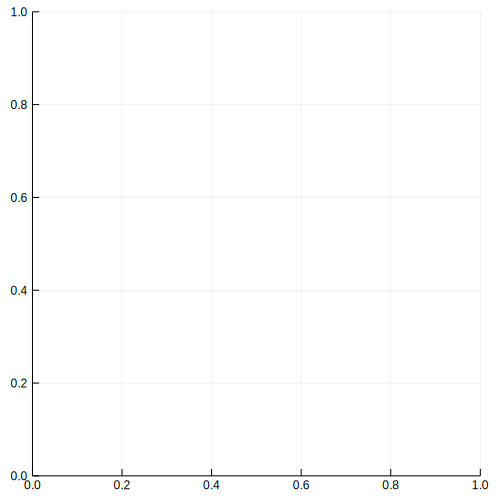

In [3]:
using Plots
plot(size=(500,500),leg=false)

Now let's create a scatter plot to show the price of a house vs. its square footage,

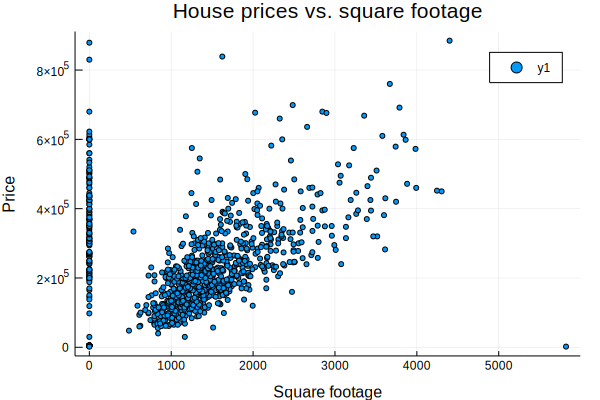

In [4]:
x = select(houses, :sq__ft)
y = select(houses, :price)
scatter(x,y,markersize=3)
xlabel!("Square footage")
ylabel!("Price")
title!("House prices vs. square footage")

*Houses with 0 square feet that cost money?*

The square footage seems to not have been recorded in these cases. 

Filtering these houses out is easy to do!

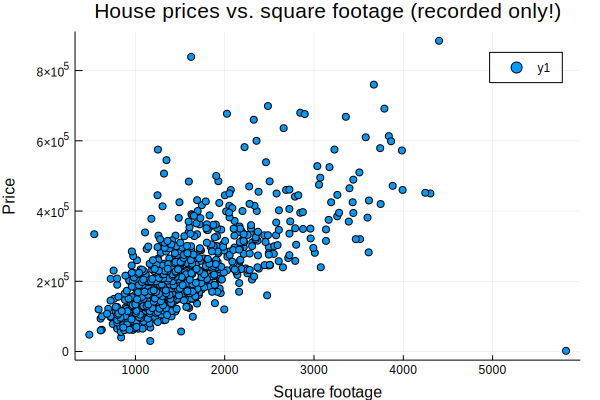

In [5]:
filtered_houses = filter(x -> x > 0, houses; select = :sq__ft)
x = select(filtered_houses, :sq__ft)
y = select(filtered_houses, :price)
scatter(x,y)
xlabel!("Square footage")
ylabel!("Price")
title!("House prices vs. square footage (recorded only!)")

This makes sense! The higher the square footage, the higher the price.

### Example 1: Kmeans Clustering

Now let's do some kmeans clustering on this data.

First, we can load the `Clustering` package to do this.

In [6]:
#Pkg.add("Clustering")
using Clustering

Let's store the features `:latitude` and `:longitude` in an array `X` that we will pass to `kmeans`.

First we add data for `:latitude` and `:longitude` to a new `DataFrame` called `X`.

In [7]:
X = select(filtered_houses, (:latitude, :longitude))

Table with 814 rows, 2 columns:
latitude  longitude
───────────────────
38.6319   -121.435
38.4789   -121.431
38.6183   -121.444
38.6168   -121.439
38.5195   -121.436
38.6626   -121.328
38.6817   -121.352
38.5351   -121.481
38.6212   -121.271
38.7009   -121.443
38.6377   -121.452
38.4707   -121.459
⋮
38.7031   -121.235
38.3898   -121.446
38.8978   -121.325
38.4679   -121.445
38.4453   -121.442
38.4174   -121.484
38.4577   -121.36
38.4999   -121.459
38.7088   -121.257
38.417    -121.397
38.6552   -121.076

For the purpose of processing the data in table `X`, we want to have this data stored in an `Array`. We'll convert `X` to an `Array` with the following bit of code:

In [8]:
Xarray = hcat(columns(X)...)

814×2 Array{Float64,2}:
 38.6319  -121.435
 38.4789  -121.431
 38.6183  -121.444
 38.6168  -121.439
 38.5195  -121.436
 38.6626  -121.328
 38.6817  -121.352
 38.5351  -121.481
 38.6212  -121.271
 38.7009  -121.443
 38.6377  -121.452
 38.4707  -121.459
 38.6187  -121.436
  ⋮               
 38.7035  -121.375
 38.7031  -121.235
 38.3898  -121.446
 38.8978  -121.325
 38.4679  -121.445
 38.4453  -121.442
 38.4174  -121.484
 38.4577  -121.36 
 38.4999  -121.459
 38.7088  -121.257
 38.417   -121.397
 38.6552  -121.076

What did we just do here?

Let's take a moment to look at each of the functions composed in the above command, one at a time.

First, we have the `columns` command. This returns a `Tuple` storing an `Array` for each column in the input data structure.

In [9]:
columns(X)

(latitude = [38.6319, 38.4789, 38.6183, 38.6168, 38.5195, 38.6626, 38.6817, 38.5351, 38.6212, 38.7009  …  38.3898, 38.8978, 38.4679, 38.4453, 38.4174, 38.4577, 38.4999, 38.7088, 38.417, 38.6552], longitude = [-121.435, -121.431, -121.444, -121.439, -121.436, -121.328, -121.352, -121.481, -121.271, -121.443  …  -121.446, -121.325, -121.445, -121.442, -121.484, -121.36, -121.459, -121.257, -121.397, -121.076])

In [10]:
columns(X)[1]

814-element Array{Float64,1}:
 38.6319
 38.4789
 38.6183
 38.6168
 38.5195
 38.6626
 38.6817
 38.5351
 38.6212
 38.7009
 38.6377
 38.4707
 38.6187
  ⋮     
 38.7035
 38.7031
 38.3898
 38.8978
 38.4679
 38.4453
 38.4174
 38.4577
 38.4999
 38.7088
 38.417 
 38.6552

The `hcat` command will build a multidimensional array from a set of input `Vector`s, or  1D `Array`s. For example,

In [11]:
hcat([1, 2, 3], [4, 5, 6])

3×2 Array{Int64,2}:
 1  4
 2  5
 3  6

We want to use `hcat` to construct a 2D `Array` (or `Matrix`) from the `Vector`s that we get from `columns`.

However, if we try to run `hcat` directly on the output of `columns`, it won't do what we expect.

In [12]:
hcat(columns(X))

1×1 Array{NamedTuples._NT_latitude_longitude{Array{Float64,1},Array{Float64,1}},2}:
 (latitude = [38.6319, 38.4789, 38.6183, 38.6168, 38.5195, 38.6626, 38.6817, 38.5351, 38.6212, 38.7009  …  38.3898, 38.8978, 38.4679, 38.4453, 38.4174, 38.4577, 38.4999, 38.7088, 38.417, 38.6552], longitude = [-121.435, -121.431, -121.444, -121.439, -121.436, -121.328, -121.352, -121.481, -121.271, -121.443  …  -121.446, -121.325, -121.445, -121.442, -121.484, -121.36, -121.459, -121.257, -121.397, -121.076])

What we want is a 2D `Array` with 814 rows, but we've accidentally created a 1x1 `Array`.

The issue is that we need to pass **the components** of the output of `columns`, **not the output** of `columns`. We can think of the "splat" command, `...`, as unraveling the data structure it follows.

Compare the difference of the two calls to `hcat`:

In [13]:
hcat([[1, 2], [3, 4]])

2×1 Array{Array{Int64,1},2}:
 [1, 2]
 [3, 4]

In [14]:
hcat([[1, 2], [3, 4]]...)

2×2 Array{Int64,2}:
 1  3
 2  4

Let's store the `Array` version of `X` in `X` itself:

In [15]:
X = hcat(columns(X)...)

814×2 Array{Float64,2}:
 38.6319  -121.435
 38.4789  -121.431
 38.6183  -121.444
 38.6168  -121.439
 38.5195  -121.436
 38.6626  -121.328
 38.6817  -121.352
 38.5351  -121.481
 38.6212  -121.271
 38.7009  -121.443
 38.6377  -121.452
 38.4707  -121.459
 38.6187  -121.436
  ⋮               
 38.7035  -121.375
 38.7031  -121.235
 38.3898  -121.446
 38.8978  -121.325
 38.4679  -121.445
 38.4453  -121.442
 38.4174  -121.484
 38.4577  -121.36 
 38.4999  -121.459
 38.7088  -121.257
 38.417   -121.397
 38.6552  -121.076

At this point, each data point is stored as a row of `X`, but we can transpose `X` to make these samples correspond to columns of `X`.

In [16]:
X = X'

2×814 Array{Float64,2}:
   38.6319    38.4789    38.6183  …    38.7088    38.417    38.6552
 -121.435   -121.431   -121.444      -121.257   -121.397  -121.076 

As a first pass at guessing how many clusters we might need, let's use the number of zip codes in our data.

(Try changing this to see how it impacts results!)

In [17]:
k = length(unique(select(filtered_houses, :zip)) )

66

We can use the `kmeans` function to do kmeans clustering!

In [18]:
C = kmeans(X, k)

Clustering.KmeansResult{Float64}([38.281 38.6584 … 39.0082 38.6712; -121.294 -121.537 … -121.036 -121.128], [56, 28, 4, 4, 54, 14, 32, 6, 45, 25  …  64, 29, 28, 53, 59, 44, 33, 20, 41, 50], [5.24408e-5, 0.000373631, 2.16635e-5, 9.15434e-5, 0.000151822, 0.000774325, 0.000218782, 0.000267481, 5.87836e-6, 0.000116867  …  4.19203e-5, 5.24133e-5, 9.4984e-6, 0.000187139, 0.000134158, 0.000169506, 4.35655e-5, 0.000526623, 5.14042e-5, 0.000114516], [12, 25, 5, 21, 10, 10, 3, 4, 12, 6  …  26, 10, 7, 4, 19, 13, 12, 16, 1, 8], [12.0, 25.0, 5.0, 21.0, 10.0, 10.0, 3.0, 4.0, 12.0, 6.0  …  26.0, 10.0, 7.0, 4.0, 19.0, 13.0, 12.0, 16.0, 1.0, 8.0], 0.2107652955710364, 10, true)

Now let's create a new table, `clustered_houses`, with all the same data as `filtered_houses` that also includes a column for the cluster to which each house has been assigned.

In [19]:
clustered_houses = setcol(filtered_houses, :cluster, C.assignments )

Table with 814 rows, 13 columns:
Columns:
#   colname    type
──────────────────────
1   street     String
2   city       String
3   zip        Int64
4   state      String
5   beds       Int64
6   baths      Int64
7   sq__ft     Int64
8   type       String
9   sale_date  String
10  price      Int64
11  latitude   Float64
12  longitude  Float64
13  cluster    Int64

In [20]:
select(clustered_houses, :cluster)

814-element Array{Int64,1}:
 56
 28
  4
  4
 54
 14
 32
  6
 45
 25
 46
 28
  4
  ⋮
 16
 20
 64
 29
 28
 53
 59
 44
 33
 20
 41
 50

Let's plot each cluster as a different color.

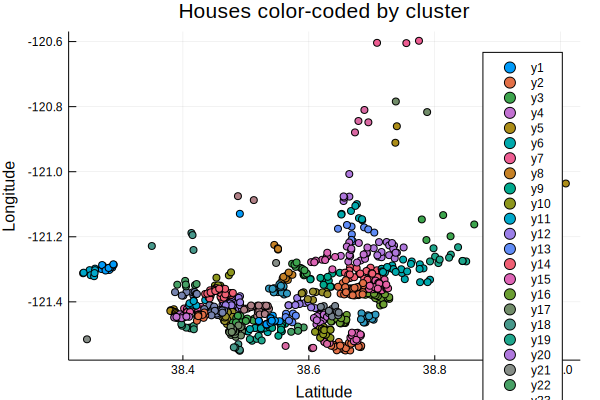

In [21]:
clusters_figure = plot()
for i = 1:k
    houses_in_cluster_i = filter(x -> x == i, clustered_houses, select = :cluster)
    xvals = select(houses_in_cluster_i, :latitude)
    yvals = select(houses_in_cluster_i, :longitude)
    scatter!(xvals, yvals, markersize=4)
end
xlabel!("Latitude")
ylabel!("Longitude")
title!("Houses color-coded by cluster")
display(clusters_figure)

And now let's try coloring them by zip code.

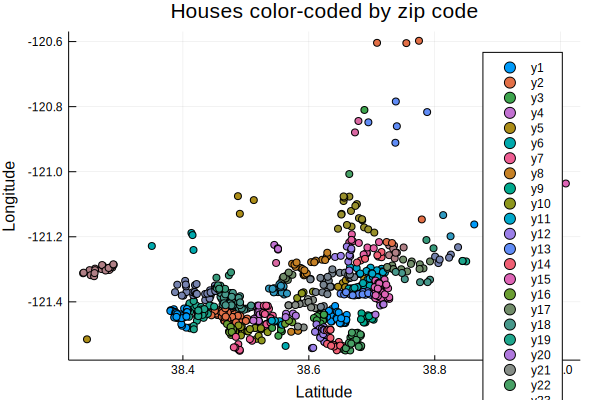

In [23]:
unique_zips = unique(select(filtered_houses, :zip))
zips_figure = plot()
for uzip in unique_zips
    subs = filter(x -> x == uzip, filtered_houses, select = :zip)
    x = select(subs, :latitude)
    y = select(subs, :longitude)
    scatter!(zips_figure,x,y)
end
xlabel!("Latitude")
ylabel!("Longitude")
title!("Houses color-coded by zip code")
display(zips_figure)

Let's see the two plots side by side.

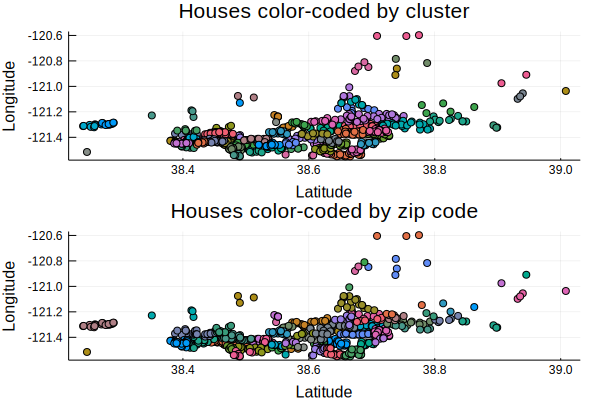

In [25]:
plot(clusters_figure,zips_figure, layout=(2, 1), legend = false)

Not exactly! but almost... Now we know that ZIP codes are not randomly assigned!

### Example 2: Nearest Neighbor with a KDTree

For this example, let's start by loading the `NearestNeighbors` package.

In [26]:
using NearestNeighbors

With this package, we'll look for the `knearest` neighbors of one of the houses, `point`.

In [54]:
knearest = 10
id = rand(1:size(X, 2))
point = X[:,id]
println("We'll find the $knearest nearest neighbors of `point`,  # $id")

We'll find the 10 nearest neighbors of `point`,  # 544


Now we can build a `KDTree` and use `knn` to look for `point`'s nearest neighbors!

In [55]:
kdtree = KDTree(X)
idxs, dists = knn(kdtree, point, knearest, true)

([544, 616, 320, 26, 610, 401, 580, 201, 747, 536], [0.0, 0.00625684, 0.00682608, 0.00919211, 0.0123255, 0.012709, 0.0136719, 0.0141769, 0.0143629, 0.0144415])

We'll first generate a plot with all of the houses in the same color,

In [56]:
x = select(filtered_houses, :latitude);
y = select(filtered_houses, :longitude);
scatter(x,y);

and then overlay the data corresponding to the nearest neighbors of `point` in a different color.

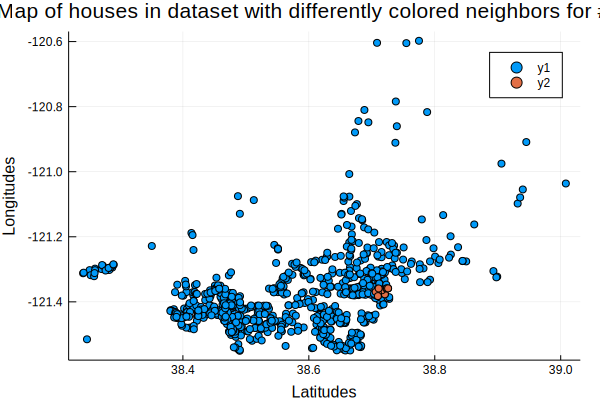

In [57]:
x = select(filtered_houses, :latitude)[idxs, :]
y = select(filtered_houses, :longitude)[idxs, :]
scatter!(x,y)
xlabel!("Latitudes")
ylabel!("Longitudes")
title!("Map of houses in dataset with differently colored neighbors for # $id")

There are those nearest neighbors in red!

We can see the cities of the neighboring houses by using the indices, `idxs`, and the feature, `:city`, to index into the `DataFrame` `filter_houses`.

In [58]:
cities = select(filtered_houses, :city)[idxs]

10-element Array{String,1}:
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"
 "ANTELOPE"

### Example 3: PCA for dimensionality reduction

Let us try to reduce the dimensions of the price/area data from the houses dataset.

We can start by grabbing the square footage and prices of the houses and storing them in an `Array`.

In [64]:
F = select(filtered_houses, (:sq__ft, :price))
F = hcat(columns(F)...)'

2×814 Array{Int64,2}:
   836   1167    796    852    797   1122  …    1477    1216    1685    1362
 59222  68212  68880  69307  81900  89921     234000  235000  235301  235738

Recall how the data looks when we plot housing prices against square footage.

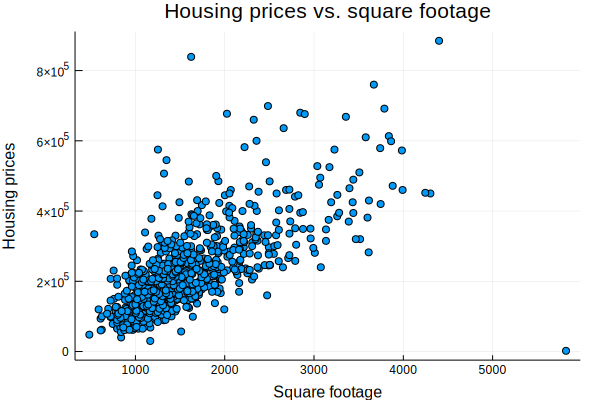

In [67]:
scatter(F[1,:],F[2,:], legend = false)
xlabel!("Square footage")
ylabel!("Housing prices")
title!("Housing prices vs. square footage")

We can use the `MultivariateStats` package to run PCA

In [68]:
# Pkg.add("MultivariateStats")
using MultivariateStats

Next we'll use `fit` to fit the model, but `fit` won't work on an `Array` `F` of `Int`s. Let's convert `F` to an `Array` of `Float`s.

In [71]:
F = convert(Array{Float64}, F)

2×814 Array{Float64,2}:
   836.0   1167.0    796.0    852.0    797.0  …    1216.0    1685.0    1362.0
 59222.0  68212.0  68880.0  69307.0  81900.0     235000.0  235301.0  235738.0

Now use `fit` to fit the model

In [72]:
M = fit(PCA, F)

PCA(indim = 2, outdim = 1, principalratio = 0.99998)

Note that you can choose the maximum dimension of the new space by setting `maxoutdim`, and you can change the method to, for example, `:svd` with the following syntax.

```julia
fit(PCA, F; maxoutdim = 1,method=:svd)
```

It seems like we only get one dimension with PCA! Let's use `transform` to map all of our 2D data in `F` to `1D` data with our model, `M`.

In [73]:
y = transform(M, F)

1×814 Array{Float64,2}:
 -170228.0  -1.61237e5  -1.6057e5  …  4551.16  5550.15  5852.95  6288.7

Let's use `reconstruct` to put our now 1D data, `y`, in a form that we can easily overlay (`Xr`) with our 2D data in `F` along the principle direction/component.

In [74]:
Xr = reconstruct(M, y)

2×814 Array{Float64,2}:
   936.922    971.477    974.039    975.681  …  1613.64         1615.32
 59221.6    68212.8    68879.3    69306.5          2.35301e5  235737.0 

And now we create that overlay, where we can see points along the principle component in red. 

(Each blue point maps uniquely to some red point!)

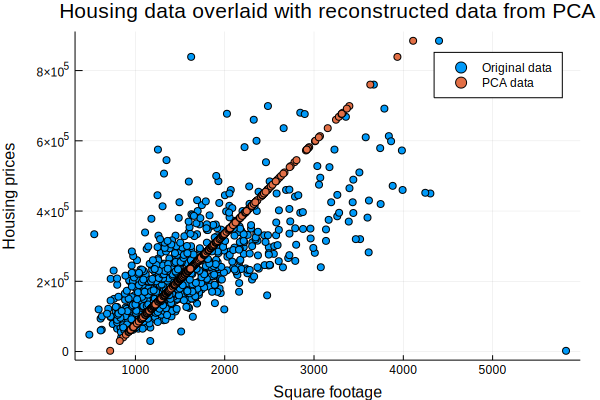

In [78]:
scatter(F[1,:],F[2,:], label = "Original data")
scatter!(Xr[1,:],Xr[2,:], label = "PCA data")
xlabel!("Square footage")
ylabel!("Housing prices")
title!("Housing data overlaid with reconstructed data from PCA")